# Laboratorio 2: Armado de un esquema de aprendizaje automático

En el laboratorio final se espera que puedan poner en práctica los conocimientos adquiridos en el curso, trabajando con un conjunto de datos de clasificación.

El objetivo es que se introduzcan en el desarrollo de un esquema para hacer tareas de aprendizaje automático: selección de un modelo, ajuste de hiperparámetros y evaluación.

El conjunto de datos a utilizar está en `./data/loan_data.csv`. Si abren el archivo verán que al principio (las líneas que empiezan con `#`) describen el conjunto de datos y sus atributos (incluyendo el atributo de etiqueta o clase).

Se espera que hagan uso de las herramientas vistas en el curso. Se espera que hagan uso especialmente de las herramientas brindadas por `scikit-learn`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.exceptions import DataConversionWarning
np.random.seed(1314)  # Para mayor determinismo
rnd_state = 42112

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)

## Carga de datos y división en entrenamiento y evaluación

La celda siguiente se encarga de la carga de datos (haciendo uso de pandas). Estos serán los que se trabajarán en el resto del laboratorio.

In [3]:
dataset = pd.read_csv("./loan_data.csv", comment="#")


# División entre instancias y etiquetas
X, y = dataset.iloc[:, 1:], dataset.TARGET

# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rnd_state)


Documentación:

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

## Ejercicio 1: Descripción de los Datos y la Tarea

Responder las siguientes preguntas:

1. ¿De qué se trata el conjunto de datos?
2. ¿Cuál es la variable objetivo que hay que predecir? ¿Qué significado tiene?
3. ¿Qué información (atributos) hay disponible para hacer la predicción?
4. ¿Qué atributos imagina ud. que son los más determinantes para la predicción?

**No hace falta escribir código para responder estas preguntas.**

El conjunto de datos se trata de diferentes prestamos bancarios a distintas personas. Lo que nos interesa predecir es si la persona pago o es deudora del prestamo.

Para poder hacer esa predicción contamos con los siguientes features:
  * TARGET: Variable Categorica. 1 = prestado adeudado - 0 = prestamo pagado
  * LOAN:   Cantidad de dinero prestado
  * MORTDUE Amount due on existing mortgage
  * VALUE   Valor de la propiedad actual
  * YOJ     Antigüedad laboral actual
  * DEROG   Number of major derogatory reports
  * DELINQ  Number of delinquent credit lines
  * CLAGE   Age of oldest trade line in months
  * NINQ    Cantidad de creditos recientes
  * CLNO    Cantidad de creditos
  * DEBTINC Debt-to-income ratio

A priori, los features más determinantes para la predicción parecen ser:
  * DEBTINC
  * LOAN
  * NINQ



Para evaluar el accuracy de la calsificación, es importante conocer cual es la distribucion de los datos en la label TARGET

In [4]:
X.dtypes

LOAN         int64
MORTDUE    float64
VALUE      float64
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

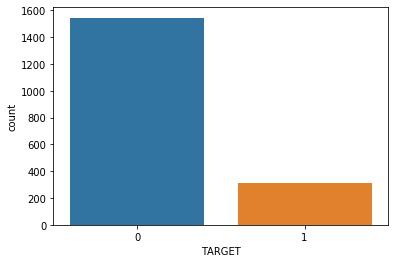

In [5]:
sns.countplot(dataset["TARGET"])

In [6]:
dataset["TARGET"].value_counts().div(dataset["TARGET"].shape[0])

0    0.833333
1    0.166667
Name: TARGET, dtype: float64

Aproximadamente el 83% de los datos es 0, por lo tanto un modelo que prediga todos 0 va a tenre un accuraxy de 83%. Tenemos que ser capaces de mejorar eso. 

Vemos si se mantiene en el training set

In [7]:
dataset

,TARGET,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,0,4700,88026.0,115506.0,6.0,0.0,0.0,182.248332,0.0,27.0,29.209023
1,0,19300,39926.0,101208.0,4.0,0.0,0.0,140.051638,0.0,14.0,31.545694
2,0,5700,71556.0,79538.0,2.0,0.0,0.0,92.643085,0.0,15.0,41.210012
3,0,13000,44875.0,57713.0,0.0,1.0,0.0,184.990324,1.0,12.0,28.602076
4,0,19300,72752.0,106084.0,11.0,0.0,0.0,193.707100,1.0,13.0,30.686106
...,...,...,...,...,...,...,...,...,...,...,...
1849,1,53400,228236.0,305514.0,6.0,0.0,0.0,11.148069,0.0,2.0,34.558417
1850,1,53600,235895.0,299772.0,5.0,0.0,0.0,112.748282,7.0,22.0,44.945929
1851,1,53600,208197.0,297280.0,4.0,1.0,1.0,160.485251,2.0,29.0,41.646731
1852,1,65500,205156.0,290239.0,2.0,0.0,0.0,98.808206,1.0,21.0,144.189001


In [9]:
y_train.value_counts().div(y_train.shape[0])

0    0.8294
1    0.1706
Name: TARGET, dtype: float64

## Ejercicio 2: Predicción con Modelos Lineales

En este ejercicio se entrenarán modelos lineales de clasificación para predecir la variable objetivo.

Para ello, deberán utilizar la clase SGDClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/sgd.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html


### Ejercicio 2.1: SGDClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador SGDClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [11]:
rnd_st = 4253143

In [12]:
scaler = StandardScaler()
sgd_cls = SGDClassifier(random_state=rnd_st)
pipe_cls = Pipeline(steps=[("std_scaler", StandardScaler()),
                           ("sgd", sgd_cls),
                          ])

In [13]:
pipe_cls.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=4253143,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

Reporte de los datos de entrenamiento

In [14]:
def print_classification_report(y_real, y_pred):
    print(f"Accuracy {accuracy_score(y_real, y_pred)}")
    print("-"*100)
    print(classification_report(y_real, y_pred))
    sns.heatmap(confusion_matrix(y_real, y_pred), 
                xticklabels=[0, 1],
                yticklabels=[0, 1],
                cmap="jet",
                annot=True,
               )
    plt.xlabel("Predicted Class")
    plt.ylabel("Real Class")
    

#### Metricas Entrenamiento

Accuracy 0.8246797033041133
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1230
           1       0.48      0.28      0.35       253

    accuracy                           0.82      1483
   macro avg       0.67      0.61      0.63      1483
weighted avg       0.80      0.82      0.81      1483



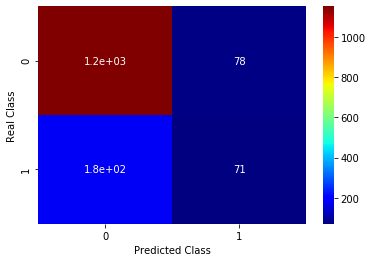

In [15]:
y_pred_train = pipe_cls.predict(X_train)
print_classification_report(y_train, y_pred_train)

In [16]:
sum(y_pred_train), sum(y_train)

(149, 253)

Tengo muchas calsificaciones False Positive. 

#### Metricas Validacion

Reporte de los datos de evaluacion

Accuracy 0.8436657681940701
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       315
           1       0.47      0.25      0.33        56

    accuracy                           0.84       371
   macro avg       0.67      0.60      0.62       371
weighted avg       0.81      0.84      0.82       371



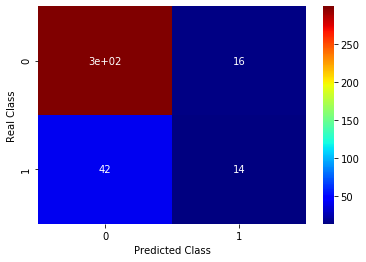

In [17]:
y_pred_test = pipe_cls.predict(X_test)
print_classification_report(y_test, y_pred_test)


Vemos como el clasificador esta prediciendo todas las clasificaciones iguales. Tranquilamente podríamos usar un rpedictor dummy que nos diga lo mismo y obtendriamos el mismo accuracy.

Esto se debe en parte a que estamos usando como **scoring** el **accuracy**. Podríamos cambiar para usar el **recall**

### Ejercicio 2.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del SGDClassifier. Como mínimo, probar diferentes funciones de loss, tasas de entrenamiento y tasas de regularización.

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión

Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
param_grid = {
    "sgd__loss": ['hinge', "perceptron", "log"], 
    "sgd__penalty":['l2', "l1", "elasticnet", None],
    "sgd__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "sgd__l1_ratio": [0.15, 0.5, 0.95]
    }
grid_sgd = GridSearchCV(pipe_cls, param_grid=param_grid, cv=5, scoring="accuracy")

In [20]:
grid_sgd.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('std_scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('sgd',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                        

In [21]:
means = grid_sgd.cv_results_['mean_test_score']
stds = grid_sgd.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_sgd.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.3f (+/-%0.03f) para %r" % (mean, std * 2, params))
print()

0.872 (+/-0.016) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.15, 'sgd__loss': 'hinge', 'sgd__penalty': None}
0.872 (+/-0.016) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'hinge', 'sgd__penalty': None}
0.872 (+/-0.016) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.95, 'sgd__loss': 'hinge', 'sgd__penalty': None}
0.871 (+/-0.022) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.15, 'sgd__loss': 'log', 'sgd__penalty': None}
0.871 (+/-0.022) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'log', 'sgd__penalty': None}
0.871 (+/-0.022) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.95, 'sgd__loss': 'log', 'sgd__penalty': None}
0.869 (+/-0.022) para {'sgd__alpha': 0.001, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'hinge', 'sgd__penalty': 'elasticnet'}
0.868 (+/-0.020) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.15, 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
0.868 (+/-0.020) para {'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.5, 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
0.868 (+/-0.020

In [22]:
grid_sgd.best_estimator_

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd',
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty=None, power_t=0.5, random_state=4253143,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [23]:
svg_best = grid_sgd.best_estimator_
svg_best.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('sgd',
                 SGDClassifier(alpha=0.01, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty=None, power_t=0.5, random_state=4253143,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

#### Metricas Entrenamiento

Accuracy 0.8712070128118679
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1230
           1       0.92      0.27      0.42       253

    accuracy                           0.87      1483
   macro avg       0.89      0.63      0.67      1483
weighted avg       0.88      0.87      0.84      1483



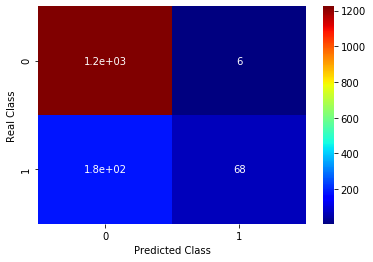

In [24]:
y_pred_train = svg_best.predict(X_train)
print_classification_report(y_train, y_pred_train)

#### Metricas Validacion

Accuracy 0.8840970350404312
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.94       315
           1       0.88      0.27      0.41        56

    accuracy                           0.88       371
   macro avg       0.88      0.63      0.67       371
weighted avg       0.88      0.88      0.86       371



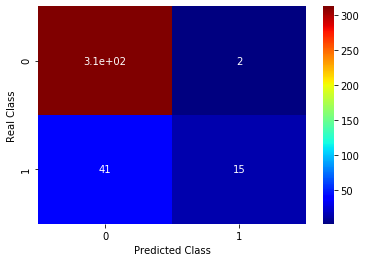

In [25]:
y_pred_test = svg_best.predict(X_test)
print_classification_report(y_test, y_pred_test)

Vemos que al algoritmo le cuesta distinguir bien los y=1 y clasifica muchas como 0. En general el error de ser 0 y clasificarlo como 1 lo comete poco.



## Ejercicio 3: Árboles de Decisión

En este ejercicio se entrenarán árboles de decisión para predecir la variable objetivo.

Para ello, deberán utilizar la clase DecisionTreeClassifier de scikit-learn.

Documentación:
- https://scikit-learn.org/stable/modules/tree.html
  - https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
- https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html

### Ejercicio 3.1: DecisionTreeClassifier con hiperparámetros por defecto

Entrenar y evaluar el clasificador DecisionTreeClassifier usando los valores por omisión de scikit-learn para todos los parámetros. Únicamente **fijar la semilla aleatoria** para hacer repetible el experimento.

Evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
tree_clf = DecisionTreeClassifier(random_state=rnd_st)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4253143, splitter='best')

#### Metricas Entrenamiento

Accuracy 1.0
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1230
           1       1.00      1.00      1.00       253

    accuracy                           1.00      1483
   macro avg       1.00      1.00      1.00      1483
weighted avg       1.00      1.00      1.00      1483



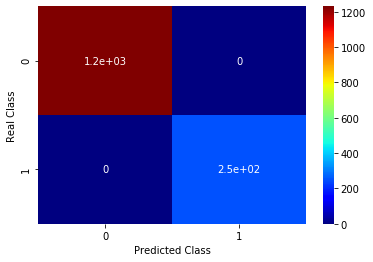

In [28]:
y_pred_train = tree_clf.predict(X_train)
print_classification_report(y_train, y_pred_train)

#### Metricas Validacion

Accuracy 0.8975741239892183
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       315
           1       0.66      0.66      0.66        56

    accuracy                           0.90       371
   macro avg       0.80      0.80      0.80       371
weighted avg       0.90      0.90      0.90       371



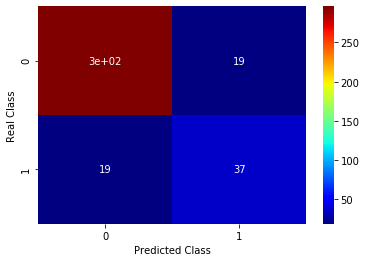

In [29]:
y_pred_test = tree_clf.predict(X_test)
print_classification_report(y_test, y_pred_test)

Es posible ver como el arbol esta overfiteando los datos de entrenamiento, ya que no comete errores de ningun tipo, pero si aparecen errores en la validacion

### Ejercicio 3.2: Ajuste de Hiperparámetros

Seleccionar valores para los hiperparámetros principales del DecisionTreeClassifier. Como mínimo, probar diferentes criterios de partición (criterion), profundidad máxima del árbol (max_depth), y cantidad mínima de samples por hoja (min_samples_leaf).

Para ello, usar grid-search y 5-fold cross-validation sobre el conjunto de entrenamiento para explorar muchas combinaciones posibles de valores.

Reportar accuracy promedio y varianza para todas las configuraciones.

Para la mejor configuración encontrada, evaluar sobre el conjunto de **entrenamiento** y sobre el conjunto de **evaluación**, reportando:
- Accuracy
- Precision
- Recall
- F1
- matriz de confusión


Documentación:
- https://scikit-learn.org/stable/modules/grid_search.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [30]:
param_grid = {
    "criterion":['gini', 'entropy'],
    "max_depth": [5, 7, 10, 12],
    "min_samples_leaf": [1, 2, 3, 5, 7, 10, 15, 20],
    }
grid_tree = GridSearchCV(tree_clf, param_grid=param_grid, cv=5, scoring="accuracy")

In [31]:
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=4253143,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [32]:
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_tree.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.4f (+/-%0.04f) para %r" % (mean, std * 2, params))
print()

0.8813 (+/-0.0181) para {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}
0.8800 (+/-0.0248) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5}
0.8800 (+/-0.0284) para {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3}
0.8793 (+/-0.0285) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 1}
0.8786 (+/-0.0313) para {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2}
0.8786 (+/-0.0289) para {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1}
0.8786 (+/-0.0276) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3}
0.8786 (+/-0.0256) para {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 2}
0.8780 (+/-0.0265) para {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 3}
0.8766 (+/-0.0232) para {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5}
0.8746 (+/-0.0391) para {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}
0.8746 (+/-0.0254) para {'criterion': 'gini', '

In [33]:
best_tree = grid_tree.best_estimator_
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4253143, splitter='best')

#### Metricas Entrenamieto 

Accuracy 0.9507754551584626
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1230
           1       0.97      0.74      0.84       253

    accuracy                           0.95      1483
   macro avg       0.96      0.87      0.90      1483
weighted avg       0.95      0.95      0.95      1483



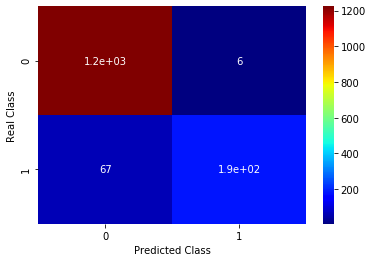

In [34]:
y_pred_train = best_tree.predict(X_train)
print_classification_report(y_train, y_pred_train)

Vemos que el modelo ya no puede overfitear los datos de entrenamiento. Veamos que pasa en validacion

#### Metricas Validacion 

Accuracy 0.8840970350404312
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       315
           1       0.70      0.41      0.52        56

    accuracy                           0.88       371
   macro avg       0.80      0.69      0.73       371
weighted avg       0.87      0.88      0.87       371



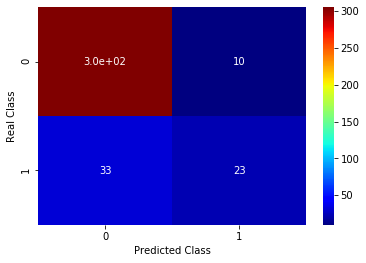

In [35]:
y_pred_test = best_tree.predict(X_test)
print_classification_report(y_test, y_pred_test)

### Extra: Prueba con usando scoring=recall

In [36]:
param_grid = {
    "criterion":['gini', 'entropy'],
    "max_depth": [5, 7, 10, 12],
    "min_samples_leaf": [1, 2, 3, 5, 7, 10, 15, 20],
    }
grid_tree_recall = GridSearchCV(tree_clf, param_grid=param_grid, cv=5, scoring="recall")

In [37]:
grid_tree_recall.fit(X_train, y_train)
means = grid_tree_recall.cv_results_['mean_test_score']
stds = grid_tree_recall.cv_results_['std_test_score']
for mean, std, params in sorted(zip(means, stds, grid_tree_recall.cv_results_['params']), 
                                key=lambda data: data[0], reverse=True):
    print("%0.4f (+/-%0.04f) para %r" % (mean, std * 2, params))
print()

0.5418 (+/-0.0955) para {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 1}
0.5304 (+/-0.1624) para {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5}
0.5184 (+/-0.1347) para {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 7}
0.5104 (+/-0.1072) para {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 3}
0.5065 (+/-0.1306) para {'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 2}
0.5026 (+/-0.1359) para {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 7}
0.4986 (+/-0.1792) para {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 3}
0.4944 (+/-0.0944) para {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1}
0.4906 (+/-0.1556) para {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 3}
0.4869 (+/-0.1898) para {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 15}
0.4867 (+/-0.1373) para {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5}
0.4867 (+/-0.1350) para {'cri

In [38]:
best_tree_recall = grid_tree_recall.best_estimator_
best_tree_recall.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=4253143, splitter='best')

#### Metricas Entrenamiento

Accuracy 0.9669588671611599
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1230
           1       0.95      0.85      0.90       253

    accuracy                           0.97      1483
   macro avg       0.96      0.92      0.94      1483
weighted avg       0.97      0.97      0.97      1483



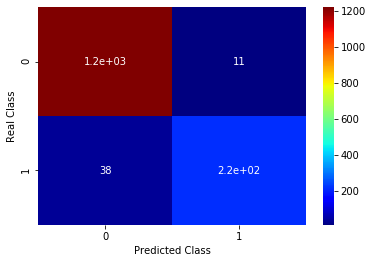

In [39]:
y_pred_train_rec = best_tree_recall.predict(X_train)
print_classification_report(y_train, y_pred_train_rec)

#### Metricas Validacion

Accuracy 0.8814016172506739
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       315
           1       0.65      0.46      0.54        56

    accuracy                           0.88       371
   macro avg       0.78      0.71      0.74       371
weighted avg       0.87      0.88      0.87       371



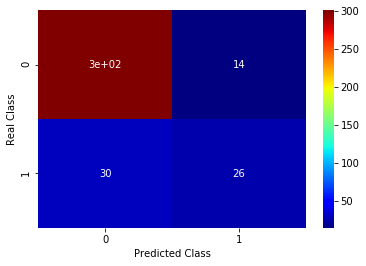

In [40]:
y_pred_test_rec = best_tree_recall.predict(X_test)
print_classification_report(y_test, y_pred_test_rec)

_________________________________
Recordemos los scores del SGDClassifier
_________________________________

Accuracy 0.8840970350404312
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.99      0.94       315
           1       0.88      0.27      0.41        56

    accuracy                           0.88       371
   macro avg       0.88      0.63      0.67       371
weighted avg       0.88      0.88      0.86       371



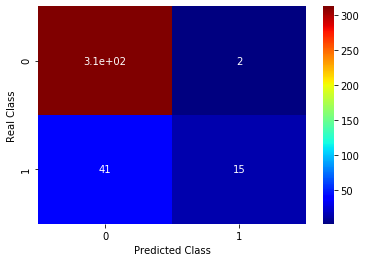

In [41]:
y_sgd_pred_test = svg_best.predict(X_test)
print_classification_report(y_test, y_sgd_pred_test)

Vemos que el arbol de decicion mejora un poquito la performance del SGD. El mayor problema parece ser que las clases estan muy desbalanceadas y al algoritmo le cuesta reconocer bien los casos donde TARGET es 1